# Deep Learning Black Scholes using TensorFlow
The goal of this case study is to perform derivative pricing from a machine learning standpoint and use supervised regression-based model to learn the Black-Scholes option pricing model from simulated data.


<a id='0'></a>
# 1. Problem Definition

In this question, we will be trying to train an Artificial Neural Network based on a linear regression model under a supervised learning framework to predict the price from a call options based on some market inputs. To perform this we will generate a series of inputs such as:

- Monenyess defined as $\frac{K}{S}$
- Time to maturity
- Volatiltiy

We will be using the Black and Scholes formula to derive the price of the option, which then we will specify as our label, while the inputs described above will be our features. The Black and Scholes formula for the price of a call option is defined as:

$$  Se^{-q \tau}\Phi(d_1) - e^{-r \tau} K\Phi(d_2) \, $$

Where:

$$  d_1 = \frac{\ln(S/K) + (r - q + \sigma^2/2)\tau}{\sigma\sqrt{\tau}}  $$

and


$$  d_2 = \frac{\ln(S/K) + (r - q - \sigma^2/2)\tau}{\sigma\sqrt{\tau}} = d_1 - \sigma\sqrt{\tau}  $$


Where we have:

- Stock price -> $S$
- Strike price -> $K$
- Risk-free rate -> $r$ (we will set this to 2.0%)
- Annual dividend yield -> $q$ (we will set this to 0 to make our analysis more easy to interpret)
- Time to maturity -> $\tau = T-t$ (represented as a unit-less fraction of one year)
- Volatility $\sigma$

As we will be using moneyness, as defined above, to feed the formula. The modified version of the option price that we will be using is:

$$  S e^{-q \tau}\Phi\left( \frac{- \ln(M) + (r+ \sigma^2/2 )\tau}{\sigma\sqrt{\tau}}\right) - S e^{-r \tau} M\Phi\left( \frac{- \ln(M) + (r - \sigma^2/2)\tau}{\sigma\sqrt{\tau}} \right) \, $$


### Python Imports

In [1]:
# Distribution functions
from scipy.stats import norm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping

# Load libraries
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# Error Metrics
from sklearn.metrics import mean_squared_error

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import chi2, f_regression

#Plotting 
from pandas.plotting import scatter_matrix

# Random Seed
np.random.seed(13)

In [2]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

<a id='1.2'></a>
### 2.2. Defining functions and parameters

#### Vol and Option Pricing Functions

In [3]:
def call_option_price(s0, M, t, v):
    
    d1=(-np.log(M)+(r+np.square(v)/2)*t)/(v*np.sqrt(t))
    d2=(-np.log(M)+(r-np.square(v)/2)*t)/(v*np.sqrt(t))
    N_d1 = norm.cdf(d1)
    N_d2 = norm.cdf(d2)
    return s0 * N_d1 - s0 * M * np.exp(-r*t) * N_d2

## Start Coursework Here

Generate option prices for a range of K, T, sigma holding r fixed 

In [4]:
r = 0.02
s0 = 100.0
N = 10000

In [5]:
Ms = np.array((0.5+1.0*np.random.random(N)))
Vs = np.array(np.random.uniform(0.1, 0.5, N)) # add randomness to the volatility
Vs2 =  Vs.copy() # we already create a copy of volatility array for the delta calculation
Ts = np.array(np.random.random(N)) * 5.0
Ts2 =  Ts.copy() # we already create a copy of time array for the delta calculation

Ps = np.array([call_option_price(100/m, m, t, v) for m, t, v in zip(Ms,Ts,Vs)])

In [6]:
# organizing and vizualizing the dataset
Y = Ps.copy()
X = np.concatenate([Ms.reshape(-1,1), Ts.reshape(-1,1),Vs.reshape(-1,1)],axis=1)

dataset = pd.DataFrame(np.concatenate([Y.reshape(-1,1), X], axis=1),
                       columns=['Price', 'Moneyness', 'Time', 'Volatility'])

In [7]:
dataset

,Price,Moneyness,Time,Volatility
0,3.735972,1.277702,1.789969,0.224770
1,39.675734,0.737541,1.231403,0.242953
2,3.653933,1.324279,4.027271,0.147598
3,0.806695,1.465749,1.784467,0.189859
4,0.549242,1.472601,1.667874,0.181977
...,...,...,...,...
9995,5.195986,1.296672,0.701826,0.456636
9996,1.048266,1.073503,0.457678,0.122301
9997,63.447906,0.632526,1.044442,0.411851
9998,4.481944,1.298178,0.587229,0.468628


In [8]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.precision', 3)
dataset.describe()

,Price,Moneyness,Time,Volatility
count,10000.000,10000.000,10000.000,10000.000
mean,30.653,1.004,2.500,0.300
std,28.202,0.289,1.446,0.116
min,0.000,0.500,0.000,0.100
25%,7.971,0.750,1.241,0.199
50%,21.738,1.008,2.488,0.301
75%,46.626,1.254,3.760,0.400
max,125.336,1.500,5.000,0.500


### 3.2. Data Visualization

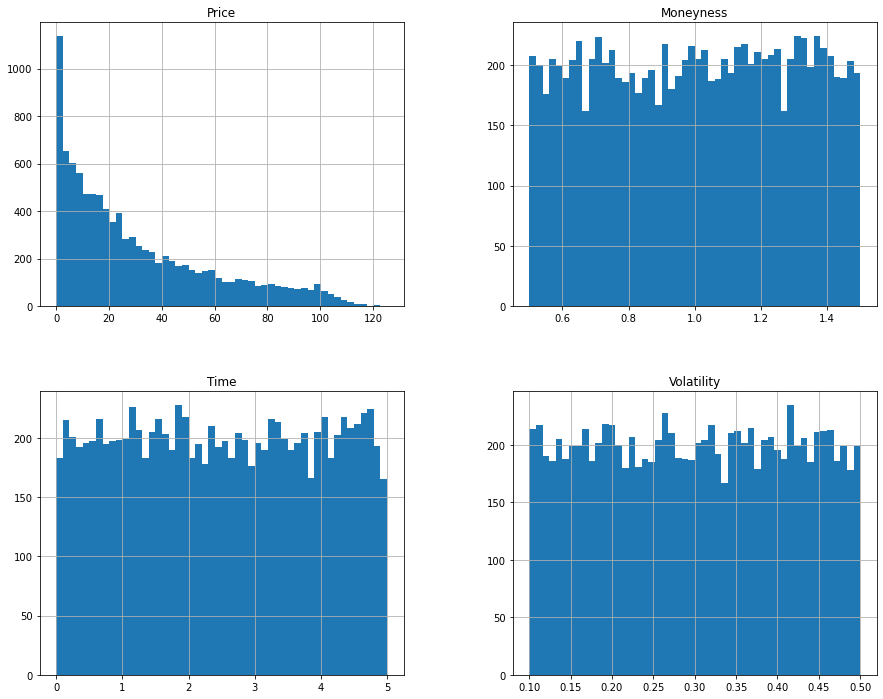

In [9]:
dataset.hist(bins=50, sharex=False, sharey=False, xlabelsize=10, ylabelsize=10, figsize=(15,12));

We can see that the price has an interesting distribution with a spike at $0$ due to all of the OTM options. We can clearly observe that Volatility is randomly distributed, just as Time and Moneyness.

### 3.3 Features Importance

In [269]:
bestfeatures = SelectKBest(k='all', score_func=f_regression)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(['Moneyness', 'Time', 'Volatility'])
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
featureScores.nlargest(10,'Score').set_index('Specs')  #print 10 best features

,Score
Specs,
Moneyness,33258.0067
Time,425.8974
Volatility,303.8305


As we can observe from the Feature Importance scores, Time and Volatility have roughly the same level of importance to predict the variables, which is low, while Moneyness carries higher predictive value.

## 4. Evaluating Models and Parameters

### 4.1. Train Test Split

In [11]:
dataset

,Price,Moneyness,Time,Volatility
0,3.736,1.278,1.790,0.225
1,39.676,0.738,1.231,0.243
2,3.654,1.324,4.027,0.148
3,0.807,1.466,1.784,0.190
4,0.549,1.473,1.668,0.182
...,...,...,...,...
9995,5.196,1.297,0.702,0.457
9996,1.048,1.074,0.458,0.122
9997,63.448,0.633,1.044,0.412
9998,4.482,1.298,0.587,0.469


In [12]:
X_train, X_test, y_train, y_test = train_test_split(dataset.iloc[:,1:], 
                                                              dataset.iloc[:,0],
                                                              random_state=42)

In [13]:
X_test.applymap('{:,.6f}'.format)

,Moneyness,Time,Volatility
6252,1.164093,4.586722,0.489577
4684,0.950294,4.648455,0.326453
1731,1.476376,3.682006,0.223627
4742,0.744891,0.696709,0.456017
4521,1.448923,2.488680,0.178372
...,...,...,...
4862,0.966597,4.599176,0.278848
7025,0.695171,3.136357,0.176345
7647,0.589599,1.435388,0.410615
7161,0.567470,2.429784,0.489693


### 4.2. Setting up a Neural Network model using Keras

We start by seting up a training function that allows us to loop through the number of hidden layers and nodes. This will be usefull in the future when we need to find the optimal architecture.

In [14]:
# We set up the learning rate at 0.001 and the standard optimizer as Adam
# Further down in our analysis we will test for the best optimizer

learning_rate=0.001
optimizer = tf.keras.optimizers.Adam(learning_rate)

def train_model(hidden_layers, nodes, optimizer=optimizer):
    model = Sequential()
    
    
    model.add(Input(shape=X_train.shape[1:])) # We have 3 nodes in the input layer, one for each parameter in X

    for x in range(0, hidden_layers):
        model.add(Dense(nodes, activation='relu')) # We use 'relu' activation function to avoid zero gradients with extreme inputs
        #model.add(Dropout(0.20))  # After a couple of tests, we conclude that adding dropout doesnt add much value to the model
    
    model.add(Dense(1)) # the final layer doesn't need no activation function since this is a linear regression model

    model.compile(loss='mean_squared_error', optimizer = optimizer) # We use MSE as loss function since this is a linear regression model
    
    return model

In [15]:
# Model summary
train_model(hidden_layers=1, nodes=50).summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                200       
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 251
Trainable params: 251
Non-trainable params: 0
_________________________________________________________________


In [16]:
# Fitting the model using random values for hidden layers and nodes. We will tune this parameters further down in our analysis

g = train_model(hidden_layers=3, nodes=50).fit(X_train, y_train, epochs=100, batch_size=200, validation_data=(X_test, y_test))

Epoch 1/100
38/38 [==============================] - 0s 4ms/step - loss: 1582.5552 - val_loss: 1338.2207
Epoch 2/100
38/38 [==============================] - 0s 2ms/step - loss: 1019.7067 - val_loss: 831.4639
Epoch 3/100
38/38 [==============================] - 0s 3ms/step - loss: 829.8539 - val_loss: 788.9569
Epoch 4/100
38/38 [==============================] - 0s 4ms/step - loss: 780.8622 - val_loss: 728.7217
Epoch 5/100
38/38 [==============================] - 0s 3ms/step - loss: 699.1473 - val_loss: 623.3903
Epoch 6/100
38/38 [==============================] - 0s 4ms/step - loss: 551.9221 - val_loss: 429.9099
Epoch 7/100
38/38 [==============================] - 0s 3ms/step - loss: 317.3186 - val_loss: 194.1539
Epoch 8/100
38/38 [==============================] - 0s 3ms/step - loss: 142.7120 - val_loss: 112.7599
Epoch 9/100
38/38 [==============================] - 0s 4ms/step - loss: 91.6503 - val_loss: 79.6135
Epoch 10/100
38/38 [==============================] - 0s 4ms/step - loss

In [17]:
final_loss_adam = g.history['loss'][-1]
final_val_loss_adam = g.history['val_loss'][-1]

In [18]:
final_val_loss_adam

0.2923331558704376

### 4.3. Evaluating Results

First, we look at the Loss x Epochs graphic to analyse the efficiency gain in our model

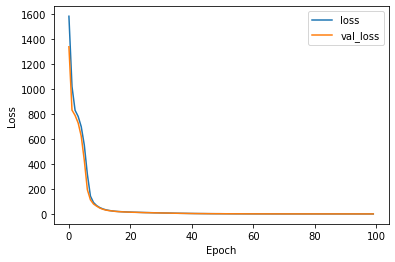

In [19]:
plt.plot(g.history['loss'], label='loss')
plt.plot(g.history['val_loss'], label='val_loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend();

As can be observed in the Loss x Epoch graph above, the loss in the model are decreasing smoothly as we increase the number of Epochs, which is a good sign.

Now, we create a Predicted x Actual price graph to have a visual on how well is our model predicting the label

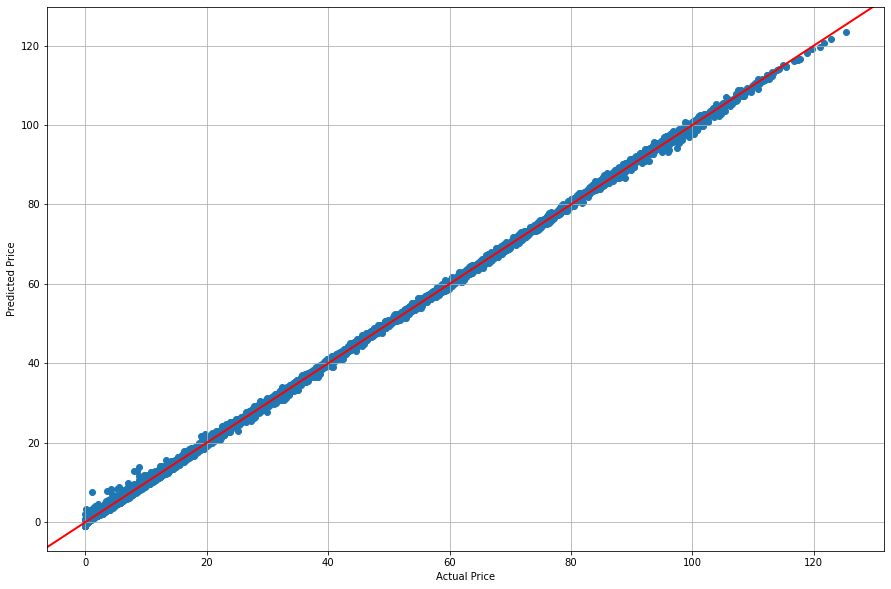

In [20]:
predictions = g.model.predict(X)
plt.figure(figsize = (15,10))
plt.scatter(Y, predictions)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.axline((15,15), (18, 18), linewidth=2, color='r')
plt.grid(True)

This graph visualy shows us how good the model is predicting the option prices on the whole dataset. We expect this to improve as we tune our parameters.

### 4.4. Choosing best optimizer

Now, before moving on to the analysis of the neural network structure, let's see if we can get better results using Rmsprop instead of Adam

In [270]:
g_2 = train_model(hidden_layers=3, nodes=50, optimizer='rmsprop').fit(X_train, y_train, epochs=100, batch_size=200,validation_data=(X_test, y_test))

Epoch 1/100
38/38 [==============================] - 1s 7ms/step - loss: 1421.0813 - val_loss: 1061.2904
Epoch 2/100
38/38 [==============================] - 0s 2ms/step - loss: 921.3691 - val_loss: 844.3446
Epoch 3/100
38/38 [==============================] - 0s 3ms/step - loss: 841.2440 - val_loss: 800.3994
Epoch 4/100
38/38 [==============================] - 0s 2ms/step - loss: 795.5644 - val_loss: 751.0375
Epoch 5/100
38/38 [==============================] - 0s 2ms/step - loss: 737.6371 - val_loss: 683.1929
Epoch 6/100
38/38 [==============================] - 0s 4ms/step - loss: 646.0214 - val_loss: 562.2637
Epoch 7/100
38/38 [==============================] - 0s 3ms/step - loss: 502.4292 - val_loss: 398.6357
Epoch 8/100
38/38 [==============================] - 0s 3ms/step - loss: 323.2632 - val_loss: 238.5809
Epoch 9/100
38/38 [==============================] - 0s 4ms/step - loss: 185.1877 - val_loss: 142.1354
Epoch 10/100
38/38 [==============================] - 0s 3ms/step - los

In [271]:
final_loss_rms = g_2.history['loss'][-1]
final_val_loss_rms = g_2.history['val_loss'][-1]

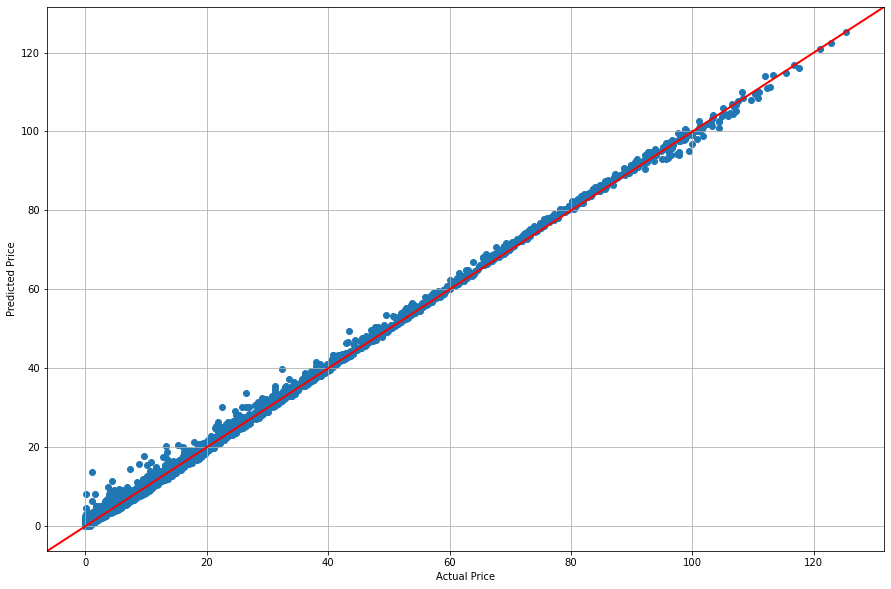

In [272]:
predictions_2 = g_2.model.predict(X_test)
plt.figure(figsize = (15,10))
plt.scatter(y_test, predictions_2)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.axline((16,16), (18, 18), linewidth=2, color='r')
plt.grid(True)

In [273]:
opt_compare = pd.DataFrame(data=[[final_val_loss_adam, final_val_loss_rms]], columns = ['Adam', 'RmsProp'])
opt_compare

,Adam,RmsProp
0,0.2923,1.4261


We can observe that the final validation loss using Adam is better, and the Prediction x Actual graph using Adam also looks better, so we will stick to that optimizer from now on.

### 4.5. Analysing Neural Network structure

To better understand and find the most adequate Neural Network structure for this model, we will retrain it with varying values for hidden layers and number of neurons per layer. We'll be using the following parameters:

* Inputs:
    * Hidden layers: [1,2,3,4]
    * Neurons: [10,20,50,100]


* Outputs:
    * 16 different NN models, containing:
        * Final loss
        * Final val loss

First, we loop through the inputs and store the results in a dataframe:

In [26]:
results_df = pd.DataFrame(columns=['Hidden layers', 'Nodes', 'Val Loss'])

for i in [1, 2, 3, 4]:
    for x in [10, 20, 50, 100]:
        nn = train_model(hidden_layers=i, nodes = x, optimizer=optimizer).fit(X_train, y_train, epochs=100, batch_size = 200, verbose=1, validation_data=(X_test, y_test))
        L = [i, x, nn.history['val_loss'][-1]]
        results_df.loc[len(results_df)] = L

# We decided to maintain the standard verbose = 1 in this loop so we can observe how val_loss goes down as the number of epochs increases in each structure

Epoch 1/100
38/38 [==============================] - 0s 5ms/step - loss: 1598.3762 - val_loss: 1464.3779
Epoch 2/100
38/38 [==============================] - 0s 2ms/step - loss: 1353.1736 - val_loss: 1240.8438
Epoch 3/100
38/38 [==============================] - 0s 2ms/step - loss: 1161.8229 - val_loss: 1079.6643
Epoch 4/100
38/38 [==============================] - 0s 2ms/step - loss: 1028.9784 - val_loss: 971.7424
Epoch 5/100
38/38 [==============================] - 0s 3ms/step - loss: 944.9589 - val_loss: 905.6652
Epoch 6/100
38/38 [==============================] - 0s 2ms/step - loss: 895.9752 - val_loss: 867.7170
Epoch 7/100
38/38 [==============================] - 0s 3ms/step - loss: 868.1700 - val_loss: 846.5023
Epoch 8/100
38/38 [==============================] - 0s 2ms/step - loss: 852.8448 - val_loss: 833.5344
Epoch 9/100
38/38 [==============================] - 0s 2ms/step - loss: 843.2878 - val_loss: 825.1786
Epoch 10/100
38/38 [==============================] - 0s 3ms/step 

In [27]:
results_df

,Hidden layers,Nodes,Val Loss
0,1.000,10.000,156.625
1,1.000,20.000,103.835
2,1.000,50.000,29.754
3,1.000,100.000,19.775
4,2.000,10.000,131.276
5,2.000,20.000,3.607
6,2.000,50.000,0.878
7,2.000,100.000,0.094
8,3.000,10.000,21.697
9,3.000,20.000,4.791


Now we find the architechture with the least Loss value

In [28]:
best_arch = results_df.sort_values('Val Loss').iloc[0]
best_arch

Hidden layers     3.000
Nodes           100.000
Val Loss          0.030
Name: 11, dtype: float64

Now that we found that 3 Hidden Layers and 100 Neurons is the best strucutre for this model, we will fit it with the name 'nn'. This will be the model used to predict values throughout the rest of the exercise.

In [63]:
nn = train_model(hidden_layers=3, nodes = 100, optimizer=optimizer).fit(X_train, y_train, epochs=100, batch_size = 200, validation_data=(X_test, y_test))

Epoch 1/100
38/38 [==============================] - 1s 6ms/step - loss: 1021.5161 - val_loss: 725.7986
Epoch 2/100
38/38 [==============================] - 0s 3ms/step - loss: 521.5392 - val_loss: 173.8525
Epoch 3/100
38/38 [==============================] - 0s 3ms/step - loss: 88.0153 - val_loss: 49.5406
Epoch 4/100
38/38 [==============================] - 0s 3ms/step - loss: 33.5419 - val_loss: 23.5176
Epoch 5/100
38/38 [==============================] - 0s 4ms/step - loss: 18.9685 - val_loss: 15.3168
Epoch 6/100
38/38 [==============================] - 0s 4ms/step - loss: 13.8469 - val_loss: 12.4346
Epoch 7/100
38/38 [==============================] - 0s 3ms/step - loss: 11.0891 - val_loss: 9.1836
Epoch 8/100
38/38 [==============================] - 0s 4ms/step - loss: 8.6874 - val_loss: 7.0266
Epoch 9/100
38/38 [==============================] - 0s 3ms/step - loss: 6.5754 - val_loss: 5.8356
Epoch 10/100
38/38 [==============================] - 0s 4ms/step - loss: 4.6185 - val_loss

Now let's take a look at the Predicted x Actual option prices graph with our optimized structure.

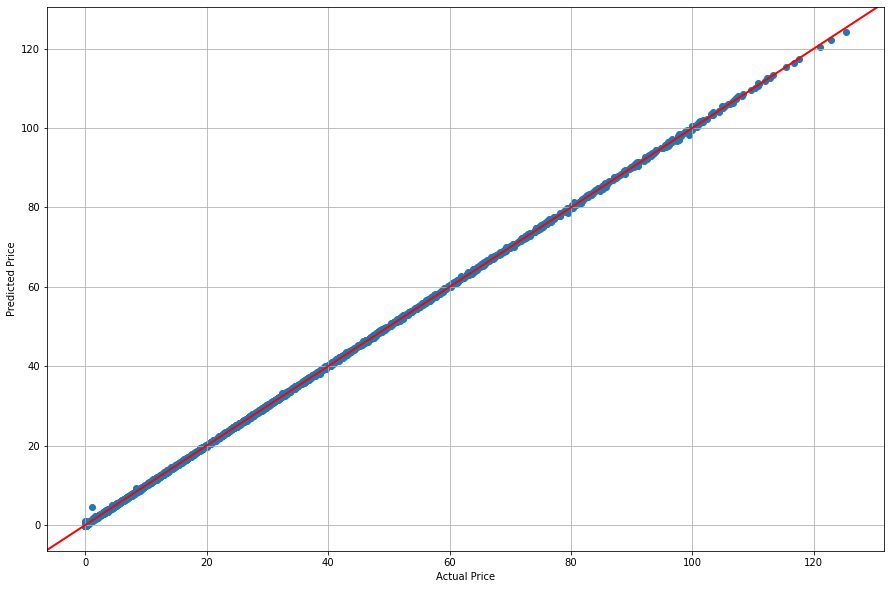

In [64]:
predictions_2 = nn.model.predict(X_test)
plt.figure(figsize = (15,10))
plt.scatter(y_test, predictions_2)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.axline((0,0), (17.5, 17.5), linewidth=2, color='r')
plt.grid(True)

We can clearly observe improvements in comparision to the first Predicted x Actual option prices graph. This illustrates the improvement in the validation loss after optimization: We started with val_loss of 0.29 using Adam with random parameters, now we have 0.045.

## 5. Calculating and Analysing delta in the optimal architechture

### 5.1 Black Scholes Call Option function

For this part of the question, we will calculate Delta using the Black-Scholes equation in the training and test examples.

$$\Delta C=\mathrm{e}^{-qt}N(d1)$$

In [65]:
# Defining the call_delta function
def call_delta(M, t, v, q):
    # Black Scholes Equation
    d1=(-np.log(M)+(r+np.square(v)/2)*t)/(v*np.sqrt(t))
    N_d1 = norm.cdf(d1)
    return np.exp(-q*t) * N_d1

In [66]:
# Testing the new function
call_delta(0.79906977, 3.76447894, 0.2489582, 0)

0.805588857405409

In [67]:
delta_BS = np.array([call_delta(M, t, v, 0) for M, t, v in zip(Ms,Ts,Vs)])

In [68]:
delta_BS

array([0.2926984 , 0.9123468 , 0.29867905, ..., 0.91121853, 0.30347908,
       0.80558886])

### 5.2 Generating deltas from the Neural Network model using the approxiamtion function

Now, we will calculate Delta using our trained Neural Network model. To do this, we will calculate the new call price P' considering a 0.01 variation in stock price, which is equivalent to a 0.0001 variation in moneyness (S0=100, Strike=100). With that value we are able to calculate Delta by applying:

$$\Delta C=(P'-P) / 0.01$$

To account for the 0.0001 change in Moneyness we will use the following equation:

$$Ms2=\frac{K}{\frac{K}{Ms}+0.01}$$

With Moneyness (Ms) defined as:

$$Ms=\frac{K}{S}$$

In [69]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [70]:
# Creating new dataset with new moneyness values

dataset_new = pd.DataFrame(dataset, columns=['Moneyness','Time','Volatility'])
Ms2=1/((((1/Ms)*100)+0.01)/100)
X_new = np.concatenate([Ms2.reshape(-1,1), Ts2.reshape(-1,1),Vs2.reshape(-1,1)],axis=1) # Ts2 and Vs2 are simple copies from previous Ts and Vs
Ps2 = np.array([call_option_price(100/m, m, t, v) for m, t, v in zip(Ms2,Ts2,Vs2)])
dataset_new = pd.DataFrame(data=np.concatenate((Ps2.reshape(-1,1),X_new),axis=1), columns=['Price,','Moneyness','Time','Volatility'])
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(dataset_new.iloc[:,1:], 
                                                              dataset_new.iloc[:,0],
                                                              random_state=42)

Now that we have our dataset with new moneyness, we can predict prices using our previously trained Neural Network model called 'nn'.
We will predict prices:

- before and after the price variation
- in and out of sample

Therefore, we will have 4 diferent predicted prices.

In [71]:
# yhat_1_IS = In sample predicted values before price variation
# yhat_1_OS = Out of sample predicted values before price vatiation

# yhat_2_IS = In sample predicted values after price variation
# yhat_2_OS = Out of sample predicted values after price variation


yhat_1_IS = nn.model.predict(X_train)
yhat_1_OS = nn.model.predict(X_test)

yhat_2_IS = nn.model.predict(X_train_new)
yhat_2_OS = nn.model.predict(X_test_new)

Now that we have the new option prices (predicted and actual), we calculate Delta using the previously defined approximation equation.

We calculate delta:

- using predicted and actual prices
- in and out of sample

Therefore, we will have 4 different deltas.

In [73]:
# delta_1_IS = In sample Delta using predicted prices from NN
# delta_1_OS = Out of sample Delta using predicted prices from NN

# delta_2_IS = In sample Delta using actual prices from dataset
# delta_2_OS = Out of sample Delta using actual prices from dataset

delta_1_IS = (yhat_2_IS - yhat_1_IS) / 0.01
delta_1_OS = (yhat_2_OS - yhat_1_OS) / 0.01

delta_2_IS = (np.array(y_train_new) - np.array(y_train)) / 0.01
delta_2_OS = (np.array(y_test_new) - np.array(y_test)) / 0.01

Now we calculate deltas using the BS pricing function.

We calculate BS deltas:

- in and out of sample

Therefore, we will have 2 different BS deltas

In [74]:
# BS Deltas in and out of sample

Ms_d_OS=dataset.iloc[y_test.index,:]['Moneyness']
Ts_d_OS=dataset.iloc[y_test.index,:]['Time']
Vs_d_OS=dataset.iloc[y_test.index,:]['Volatility']

delta_BS_OS = np.array([call_delta(M, t, v, 0) for M, t, v in zip(Ms_d_OS,Ts_d_OS,Vs_d_OS)])

Ms_d_IS=dataset.iloc[y_train.index,:]['Moneyness']
Ts_d_IS=dataset.iloc[y_train.index,:]['Time']
Vs_d_IS=dataset.iloc[y_train.index,:]['Volatility']

delta_BS_IS = np.array([call_delta(M, t, v, 0) for M, t, v in zip(Ms_d_IS,Ts_d_IS,Vs_d_IS)])


# Moneyness after price shock
Ms_n_IS = X_train_new['Moneyness']
Ms_n_OS = X_test_new['Moneyness']

### 5.3 Analysing Neural Network model delta

Now that we have all deltas and prices, we will start our analysis.

The first step is to create two comparison DataFrames containing all the information we need, one for in sample analysis and another for out of sample analysis.

In [75]:
# Comparison In Sample

comparison_IS = pd.DataFrame(data=yhat_2_IS.reshape(-1,1), columns=['yhat_2_IS'])
comparison_IS['yhat_1_IS'] = pd.DataFrame(yhat_1_IS.reshape(-1,1))
comparison_IS['delta_1_IS'] = pd.DataFrame(delta_1_IS.reshape(-1,1))
comparison_IS['y_2_IS'] = pd.DataFrame(np.array(y_train_new).reshape(-1,1))
comparison_IS['y_1_IS'] = pd.DataFrame(np.array(y_train).reshape(-1,1))
comparison_IS['delta_2_IS'] = pd.DataFrame(delta_2_IS.reshape(-1,1))
comparison_IS['delta_BS_IS'] = pd.DataFrame(delta_BS_IS.reshape(-1,1))
comparison_IS['Ms_2_IS'] = pd.DataFrame(Ms_n_IS.values)
comparison_IS['Ms_1_IS'] = pd.DataFrame(Ms_d_IS.values)
comparison_IS['Ts_IS'] = pd.DataFrame(Ts_d_IS.values)
comparison_IS['Vs_IS'] = pd.DataFrame(Vs_d_IS.values)

comparison_IS

,yhat_2_IS,yhat_1_IS,delta_1_IS,y_2_IS,y_1_IS,delta_2_IS,delta_BS_IS,Ms_2_IS,Ms_1_IS,Ts_IS,Vs_IS
0,53.1781,53.1698,0.8301,52.9146,52.9062,0.8431,0.8431,0.7081,0.7082,2.0375,0.3604
1,9.1793,9.1749,0.4380,9.2245,9.2203,0.4212,0.4211,1.4319,1.4321,3.6832,0.3034
2,17.4730,17.4660,0.6962,17.4729,17.4663,0.6651,0.6650,0.9287,0.9288,0.4999,0.4365
3,8.2349,8.2305,0.4368,8.3163,8.3119,0.4413,0.4413,1.2621,1.2622,4.7975,0.1808
4,31.1253,31.1194,0.5838,31.1399,31.1332,0.6672,0.6672,1.1559,1.1561,4.1783,0.4836
...,...,...,...,...,...,...,...,...,...,...,...
7495,11.3518,11.3472,0.4616,11.3147,11.3100,0.4631,0.4631,1.3318,1.3319,3.1565,0.3277
7496,80.2122,80.2022,1.0017,80.1365,80.1267,0.9773,0.9773,0.5622,0.5622,0.8625,0.3470
7497,73.6776,73.6673,1.0284,73.5406,73.5306,1.0000,1.0000,0.5841,0.5841,1.1843,0.1342
7498,6.5426,6.5386,0.4086,6.4038,6.3991,0.4631,0.4630,1.1607,1.1608,4.8861,0.1090


In [76]:
# Comparison Out of Sample

comparison_OS = pd.DataFrame(data=yhat_2_OS.reshape(-1,1), columns=['yhat_2_OS'])
comparison_OS['yhat_1_OS'] = pd.DataFrame(yhat_1_OS.reshape(-1,1))
comparison_OS['delta_1_OS'] = pd.DataFrame(delta_1_OS.reshape(-1,1))
comparison_OS['y_2_OS'] = pd.DataFrame(np.array(y_test_new).reshape(-1,1))
comparison_OS['y_1_OS'] = pd.DataFrame(np.array(y_test).reshape(-1,1))
comparison_OS['delta_2_OS'] = pd.DataFrame(delta_2_OS.reshape(-1,1))
comparison_OS['delta_BS_OS'] = pd.DataFrame(delta_BS_OS.reshape(-1,1))
comparison_OS['Ms_2_OS'] = pd.DataFrame(Ms_n_OS.values)
comparison_OS['Ms_1_OS'] = pd.DataFrame(Ms_d_OS.values)
comparison_OS['Ts_OS'] = pd.DataFrame(Ts_d_OS.values)
comparison_OS['Vs_OS'] = pd.DataFrame(Vs_d_OS.values)

comparison_OS

,yhat_2_OS,yhat_1_OS,delta_1_OS,y_2_OS,y_1_OS,delta_2_OS,delta_BS_OS,Ms_2_OS,Ms_1_OS,Ts_OS,Vs_OS
0,32.5371,32.5305,0.6565,32.8132,32.8064,0.6797,0.6797,1.1640,1.1641,4.5867,0.4896
1,34.6908,34.6839,0.6874,34.6088,34.6017,0.7111,0.7110,0.9502,0.9503,4.6485,0.3265
2,4.5024,4.4997,0.2647,4.5145,4.5115,0.3010,0.3009,1.4762,1.4764,3.6820,0.2236
3,40.6451,40.6361,0.8972,40.7541,40.7456,0.8415,0.8415,0.7448,0.7449,0.6967,0.4560
4,1.4984,1.4966,0.1780,1.4343,1.4328,0.1587,0.1586,1.4487,1.4489,2.4887,0.1784
...,...,...,...,...,...,...,...,...,...,...,...
2495,29.6798,29.6727,0.7113,29.4984,29.4915,0.6949,0.6948,0.9665,0.9666,4.5992,0.2788
2496,51.8027,51.7933,0.9369,51.3633,51.3540,0.9359,0.9359,0.6951,0.6952,3.1364,0.1763
2497,76.2099,76.2001,0.9781,76.4298,76.4207,0.9159,0.9159,0.5896,0.5896,1.4354,0.4106
2498,92.7843,92.7755,0.8858,92.2438,92.2349,0.8825,0.8825,0.5674,0.5675,2.4298,0.4897


Now we will create Comparison Graphs between the NN Delta and the BS Deltas, both In sample and Out of sample.

This will give us a visual perspective on how well our model is predicting deltas in comparision to the actual Black Scholes deltas.

Text(0.5, 1.0, 'Out of Sample - NN Delta approx x BS Delta')

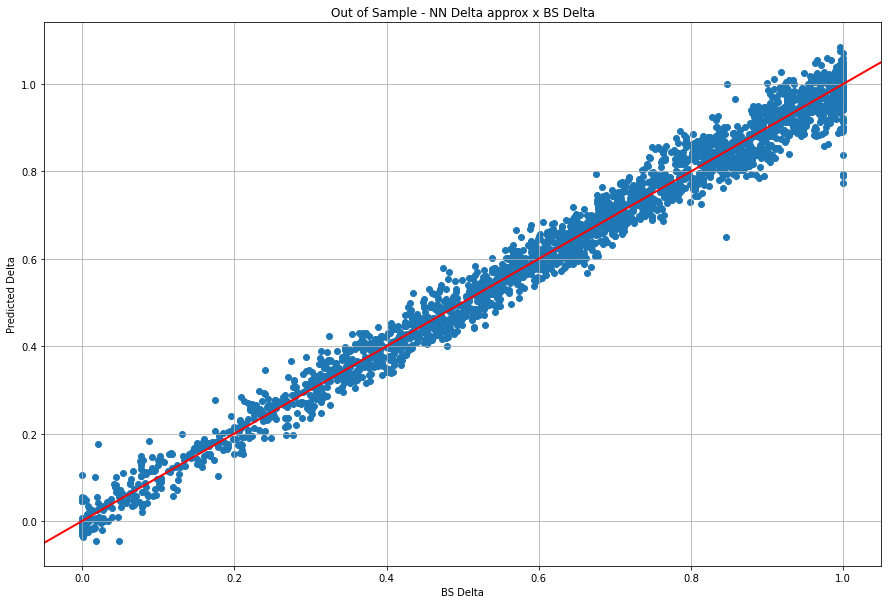

In [77]:
# Out of Sample
plt.figure(figsize = (15,10))
plt.scatter(delta_BS_OS,delta_1_OS)
plt.xlabel("BS Delta")
plt.ylabel("Predicted Delta")
plt.axline((0,0), (1, 1), linewidth=2, color='r')
plt.grid(True)
plt.title('Out of Sample - NN Delta approx x BS Delta')

Text(0.5, 1.0, 'In Sample - NN Delta approx x BS Delta')

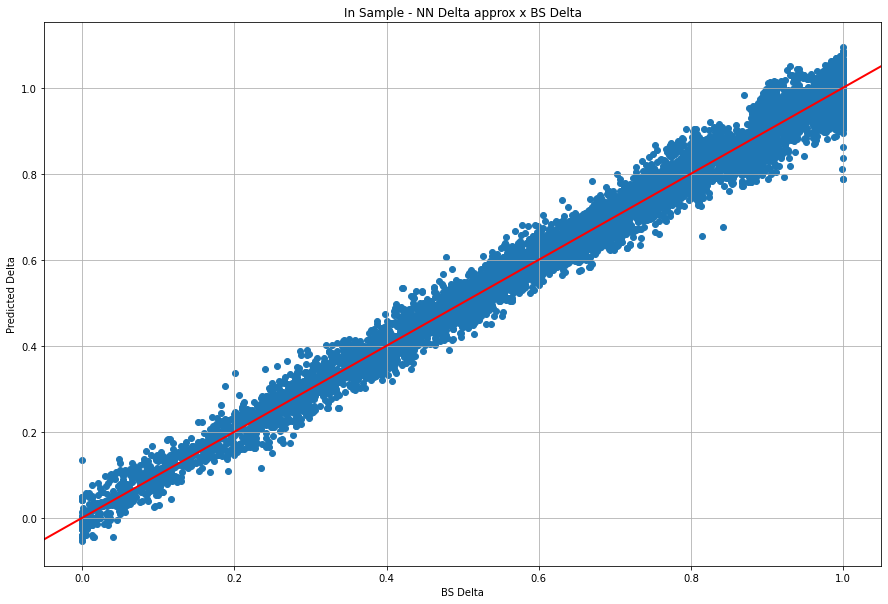

In [78]:
# In Sample
plt.figure(figsize = (15,10))
plt.scatter(delta_BS_IS,delta_1_IS)
plt.xlabel("BS Delta")
plt.ylabel("Predicted Delta")
plt.axline((0,0), (1, 1), linewidth=2, color='r')
plt.grid(True)
plt.title('In Sample - NN Delta approx x BS Delta')

As can be observed from the In sample and Out of sample deltas comparision, the model is predicting the deltas reasonably well.

The prediction error in Deltas is clearly higher than that of the Option Prices. This happens because of the multiplication effect of error in the approximation function of delta.

$$\Delta C=(P'-P) / 0.01$$

When we use the above formula, all errors that occur in the model are divided by 0.01, which has the same effect as to multiplying by 100.

### 5.4 Plotting Delta x Moneyness and Delta x Volatility for the 16 previously defined architectures 

In this step we will create graphs comparing our predicted Deltas against Volatility and Moneyness.

We will use all 16 previously defined architectures and organize them in graphs together with Black Scholes deltas.

To begin, we will calculate 4 new datasets:

- Two with varying values for Moneyness, with fixed Volatility and Time.
    - One with standard prices (name: X_test_g1)
    - One with prices increased by 0.01 (name: X_test_g1_s)
- Two with varying values for Volatility, with fixed Moneyness and Time
    - One with standard prices (name: X_test_g2)
    - One with prices increased by 0.01 (name: X_test_g2_s)
    
    
In this section we will also calculate 2 new Black Scholes deltas using the new datasets:

- One using the dataset with varying Moneyness (name: delta_g1)
- One using the dataset with varying Volatility (name: delta_g2)

In [239]:
# Creating empty dataframes for storying delta values
deltas_g1 = pd.DataFrame(index=range(0,250), columns=['1x10', '1x20', '1x50', '1x100', '2x10', '2x20', '2x50', '2x100', 
                                                   '3x10', '3x20', '3x50', '3x100', '4x10', '4x20', '4x50', '4x100'])
deltas_g2 = deltas_g1.copy()

# Moneyness varies, time and volatility fixed
Ms_g1 = np.array((0.5+1.0*np.random.random(250)))
Vs_g1 = np.ones(250)*0.3
Ts_g1 = np.ones(250)
Ms2_g1 = 1/((((1/Ms_g1)*100)+0.01)/100)

Ps_g1 = np.array([call_option_price(100/m, m, t, v) for m, t, v in zip(Ms_g1,Ts_g1,Vs_g1)])
X_test_g1 = np.concatenate([Ms_g1.reshape(-1,1), Ts_g1.reshape(-1,1), Vs_g1.reshape(-1,1)],axis=1)
X_test_g1_s = np.concatenate([Ms2_g1.reshape(-1,1), Ts_g1.reshape(-1,1), Vs_g1.reshape(-1,1)],axis=1)
delta_g1 =  np.array([call_delta(M, t, v, 0) for M, t, v in zip(Ms_g1,Ts_g1,Vs_g1)])

# Volatility varies, time and moneyness fixed
Ms_g2 = np.ones(250)*1.5 # we fix moneyness in 1.5 in order to have a bigger variation in delta as we change volatility
Vs_g2 = np.array(np.random.uniform(0.1, 0.5, 250))
Ts_g2 = np.ones(250)
Ms2_g2 = 1/((((1/Ms_g2)*100)+0.01)/100)

Ps_g2 = np.array([call_option_price(100/m, m, t, v) for m, t, v in zip(Ms_g2,Ts_g2,Vs_g2)])
X_test_g2 = np.concatenate([Ms_g2.reshape(-1,1), Ts_g2.reshape(-1,1), Vs_g2.reshape(-1,1)],axis=1)
X_test_g2_s = np.concatenate([Ms2_g2.reshape(-1,1), Ts_g2.reshape(-1,1), Vs_g2.reshape(-1,1)],axis=1)
delta_g2 =  np.array([call_delta(M, t, v, 0) for M, t, v in zip(Ms_g2,Ts_g2,Vs_g2)])

Now we will build the Delta x Moneyness Graphs.

We will group the graphs by number of nodes in order to have a better visualization of the overall results.

The process to do this will be the following:

1. Fit the model with the respective architecture
2. Predict option prices before (yhat_1) and after price change (yhat_2) using the fitted model
3. Calculate delta using predicted prices and approximation equation
4. Store delta in dataframe for deltas with varying moneyness
5. Loop through all the architectures using step 1 to 4
6. Plot 4 different graphs with deltas in Y axis and moneyness in X axis:
    - One with Black Scholes and all combinations of 10 neurons architecture (1,2,3 and 4 hidden layers)
    - One with Black Scholes and all combinations of 20 neurons architecture (1,2,3 and 4 hidden layers)
    - One with Black Scholes and all combinations of 50 neurons architecture (1,2,3 and 4 hidden layers)
    - One with Black Scholes and all combinations of 100 neurons architecture (1,2,3 and 4 hidden layers)

In [255]:
k=0
for i in [1, 2, 3, 4]:
    for x in [10, 20, 50, 100]:
        nn = train_model(hidden_layers=i, nodes = x, optimizer=optimizer).fit(X_train, y_train, epochs=100, batch_size = 200,
                                                                              verbose=0, validation_data=(X_test, y_test))
        yhat_1 = nn.model.predict(X_test_g1) # predicting option prices before change in stock price
        yhat_2 = nn.model.predict(X_test_g1_s) # predicting option prices after change in stock price
        delta_t = (yhat_2 - yhat_1) / 0.01 # calculating delta based on option price change
        deltas_g1[deltas_g1.columns[k]] = delta_t # storing deltas in a single dataframe
        k = k+1

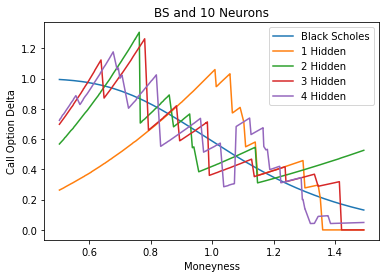

In [257]:
graph=pd.DataFrame(data=[Ms_g1,delta_g1,deltas_g1.iloc[:,0],deltas_g1.iloc[:,4],deltas_g1.iloc[:,8],deltas_g1.iloc[:,12]], index=['mon','del','del1','del2','del3','del4']).T
graph.sort_values(by=['mon'],inplace=True)
plt.plot(graph['mon'], graph['del'], label='Black Scholes')
plt.plot(graph['mon'], graph['del1'], label='1 Hidden')
plt.plot(graph['mon'], graph['del2'], label='2 Hidden')
plt.plot(graph['mon'], graph['del3'], label='3 Hidden')
plt.plot(graph['mon'], graph['del4'], label='4 Hidden')
plt.xlabel("Moneyness")
plt.ylabel("Call Option Delta")
plt.title("BS and 10 Neurons")
plt.legend();

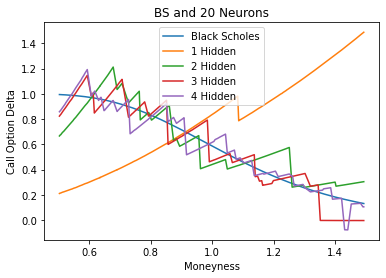

In [258]:
graph=pd.DataFrame(data=[Ms_g1,delta_g1,deltas_g1.iloc[:,1],deltas_g1.iloc[:,5],deltas_g1.iloc[:,9],deltas_g1.iloc[:,13]], index=['mon','del','del1','del2','del3','del4']).T
graph.sort_values(by=['mon'],inplace=True)
plt.plot(graph['mon'], graph['del'], label='Black Scholes')
plt.plot(graph['mon'], graph['del1'], label='1 Hidden')
plt.plot(graph['mon'], graph['del2'], label='2 Hidden')
plt.plot(graph['mon'], graph['del3'], label='3 Hidden')
plt.plot(graph['mon'], graph['del4'], label='4 Hidden')
plt.xlabel("Moneyness")
plt.ylabel("Call Option Delta")
plt.title("BS and 20 Neurons")
plt.legend();

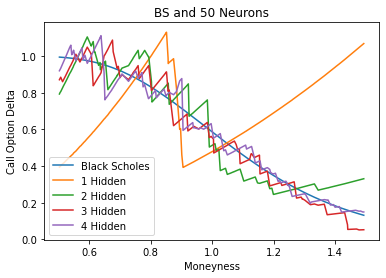

In [259]:
graph=pd.DataFrame(data=[Ms_g1,delta_g1,deltas_g1.iloc[:,2],deltas_g1.iloc[:,6],deltas_g1.iloc[:,10],deltas_g1.iloc[:,14]], index=['mon','del','del1','del2','del3','del4']).T
graph.sort_values(by=['mon'],inplace=True)
plt.plot(graph['mon'], graph['del'], label='Black Scholes')
plt.plot(graph['mon'], graph['del1'], label='1 Hidden')
plt.plot(graph['mon'], graph['del2'], label='2 Hidden')
plt.plot(graph['mon'], graph['del3'], label='3 Hidden')
plt.plot(graph['mon'], graph['del4'], label='4 Hidden')
plt.xlabel("Moneyness")
plt.ylabel("Call Option Delta")
plt.title("BS and 50 Neurons")
plt.legend();

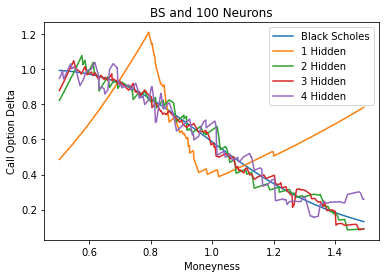

In [260]:
graph=pd.DataFrame(data=[Ms_g1,delta_g1,deltas_g1.iloc[:,3],deltas_g1.iloc[:,7],deltas_g1.iloc[:,11],deltas_g1.iloc[:,15]], index=['mon','del','del1','del2','del3','del4']).T
graph.sort_values(by=['mon'],inplace=True)
plt.plot(graph['mon'], graph['del'], label='Black Scholes')
plt.plot(graph['mon'], graph['del1'], label='1 Hidden')
plt.plot(graph['mon'], graph['del2'], label='2 Hidden')
plt.plot(graph['mon'], graph['del3'], label='3 Hidden')
plt.plot(graph['mon'], graph['del4'], label='4 Hidden')
plt.xlabel("Moneyness")
plt.ylabel("Call Option Delta")
plt.title("BS and 100 Neurons")
plt.legend();

Now we will build the Delta x Volatility Graphs.

We will again group the graphs by number of nodes in order to have a better visualization of the overall results.

The process to do this will be the following:

1. Fit the model with the respective architecture
2. Predict option prices before (yhat_1) and after price change (yhat_2) using the fitted model
3. Calculate delta using predicted prices and approximation equation
4. Store delta in dataframe for deltas with varying volatility
5. Loop through all the architectures using step 1 to 4
6. Plot 4 different graphs with deltas in Y axis and moneyness in X axis:
    - One with Black Scholes and all combinations of 10 neurons architecture (1,2,3 and 4 hidden layers)
    - One with Black Scholes and all combinations of 20 neurons architecture (1,2,3 and 4 hidden layers)
    - One with Black Scholes and all combinations of 50 neurons architecture (1,2,3 and 4 hidden layers)
    - One with Black Scholes and all combinations of 100 neurons architecture (1,2,3 and 4 hidden layers)

In [261]:
k=0
for i in [1, 2, 3, 4]:
    for x in [10, 20, 50, 100]:
        nn = train_model(hidden_layers=i, nodes = x, optimizer=optimizer).fit(X_train, y_train, epochs=100, batch_size = 200,
                                                                              verbose=0, validation_data=(X_test, y_test))
        yhat_1 = nn.model.predict(X_test_g2) # predicting option prices before change in stock price
        yhat_2 = nn.model.predict(X_test_g2_s) # predicting option prices after change in stock price
        delta_t = (yhat_2 - yhat_1) / 0.01 # calculating delta based on option price change
        deltas_g2[deltas_g2.columns[k]] = delta_t # storing deltas in a single dataframe
        k = k+1

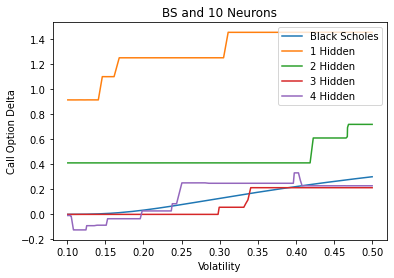

In [263]:
graph=pd.DataFrame(data=[Vs_g2,delta_g2,deltas_g2.iloc[:,0],deltas_g2.iloc[:,4],deltas_g2.iloc[:,8],deltas_g2.iloc[:,12]], index=['mon','del','del1','del2','del3','del4']).T
graph.sort_values(by=['mon'],inplace=True)
plt.plot(graph['mon'], graph['del'], label='Black Scholes')
plt.plot(graph['mon'], graph['del1'], label='1 Hidden')
plt.plot(graph['mon'], graph['del2'], label='2 Hidden')
plt.plot(graph['mon'], graph['del3'], label='3 Hidden')
plt.plot(graph['mon'], graph['del4'], label='4 Hidden')
plt.xlabel("Volatility")
plt.ylabel("Call Option Delta")
plt.title("BS and 10 Neurons")
plt.legend();

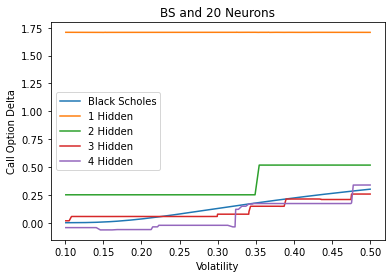

In [264]:
graph=pd.DataFrame(data=[Vs_g2,delta_g2,deltas_g2.iloc[:,1],deltas_g2.iloc[:,5],deltas_g2.iloc[:,9],deltas_g2.iloc[:,13]], index=['mon','del','del1','del2','del3','del4']).T
graph.sort_values(by=['mon'],inplace=True)
plt.plot(graph['mon'], graph['del'], label='Black Scholes')
plt.plot(graph['mon'], graph['del1'], label='1 Hidden')
plt.plot(graph['mon'], graph['del2'], label='2 Hidden')
plt.plot(graph['mon'], graph['del3'], label='3 Hidden')
plt.plot(graph['mon'], graph['del4'], label='4 Hidden')
plt.xlabel("Volatility")
plt.ylabel("Call Option Delta")
plt.title("BS and 20 Neurons")
plt.legend();

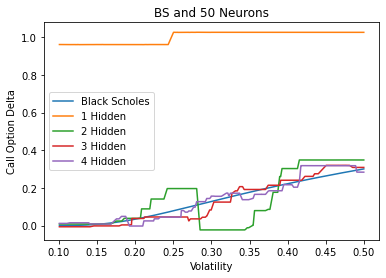

In [265]:
graph=pd.DataFrame(data=[Vs_g2,delta_g2,deltas_g2.iloc[:,2],deltas_g2.iloc[:,6],deltas_g2.iloc[:,10],deltas_g2.iloc[:,14]], index=['mon','del','del1','del2','del3','del4']).T
graph.sort_values(by=['mon'],inplace=True)
plt.plot(graph['mon'], graph['del'], label='Black Scholes')
plt.plot(graph['mon'], graph['del1'], label='1 Hidden')
plt.plot(graph['mon'], graph['del2'], label='2 Hidden')
plt.plot(graph['mon'], graph['del3'], label='3 Hidden')
plt.plot(graph['mon'], graph['del4'], label='4 Hidden')
plt.xlabel("Volatility")
plt.ylabel("Call Option Delta")
plt.title("BS and 50 Neurons")
plt.legend();

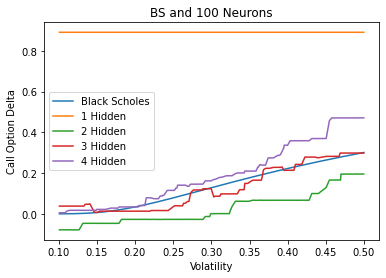

In [266]:
graph=pd.DataFrame(data=[Vs_g2,delta_g2,deltas_g2.iloc[:,3],deltas_g2.iloc[:,7],deltas_g2.iloc[:,11],deltas_g2.iloc[:,15]], index=['mon','del','del1','del2','del3','del4']).T
graph.sort_values(by=['mon'],inplace=True)
plt.plot(graph['mon'], graph['del'], label='Black Scholes')
plt.plot(graph['mon'], graph['del1'], label='1 Hidden')
plt.plot(graph['mon'], graph['del2'], label='2 Hidden')
plt.plot(graph['mon'], graph['del3'], label='3 Hidden')
plt.plot(graph['mon'], graph['del4'], label='4 Hidden')
plt.xlabel("Volatility")
plt.ylabel("Call Option Delta")
plt.title("BS and 100 Neurons")
plt.legend();